In [1]:

%pip install torch --user


  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.8.93-py3-none-manylinux2010_x86_64.manylinux_2_12_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_runtime_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cuda_cupti_cu12-12.8.90-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cudnn_cu12-9.10.2.21-py3-none-manylinux_2_27_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_cublas_cu12-12.8.4.1-py3-none-manylinux_2_27_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cufft_cu12-11.3.3.83-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_curand_cu12-10.3.9.90-py3-none-manylinux_2_27_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_cusolver_cu12-11.7.3.90-py3-none-manylinux_2_27_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_cusparse_cu12-12.5.8.93-py3-none-manylinux2014_x8

In [1]:
import torch
import torch.nn as nn

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


PyTorch version: 2.9.1+cu128
CUDA available: False


In [2]:
import pandas as pd
import numpy as np

chl_path = "NC_chlorophyll_daily_2014_2024.csv"
prcp_path = "NC_precip_daily_2014_2024.csv"

df_chl = pd.read_csv(chl_path)
df_prcp = pd.read_csv(prcp_path)

print("Chl columns:", df_chl.columns)
print("Precip columns:", df_prcp.columns)


Chl columns: Index(['date', 'chlorophyll'], dtype='object')
Precip columns: Index(['time', 'precip'], dtype='object')


In [3]:
import pandas as pd
import numpy as np

chl_path = "NC_chlorophyll_daily_2014_2024.csv"
prcp_path = "NC_precip_daily_2014_2024.csv"

df_chl = pd.read_csv(chl_path)
df_prcp = pd.read_csv(prcp_path)

print("Chl columns:", df_chl.columns)
print("Precip columns:", df_prcp.columns)

DATE_COL = "date"          
CHL_COL  = "chlorophyll"   
PRCP_COL = "precip"       


df_chl[DATE_COL]  = pd.to_datetime(df_chl[DATE_COL])
df_prcp["time"]   = pd.to_datetime(df_prcp["time"])   


df_prcp = df_prcp.rename(columns={"time": DATE_COL})


df_chl = df_chl.sort_values(DATE_COL)
df_prcp = df_prcp.sort_values(DATE_COL)


df = pd.merge(
    df_chl[[DATE_COL, CHL_COL]],
    df_prcp[[DATE_COL, PRCP_COL]],
    on=DATE_COL,
    how="inner"
)


start = pd.Timestamp("2014-01-01")
end   = pd.Timestamp("2024-12-01")
df = df[(df[DATE_COL] >= start) & (df[DATE_COL] <= end)].copy()


df.set_index(DATE_COL, inplace=True)

print(df.head())
print(df.tail())
print("Missing values per column:")
print(df.isna().sum())


Chl columns: Index(['date', 'chlorophyll'], dtype='object')
Precip columns: Index(['time', 'precip'], dtype='object')
            chlorophyll    precip
date                             
2014-01-03     3.115033  0.806732
2014-01-04     2.397363  0.000000
2014-01-06     0.342084  9.834883
2014-01-07     2.153748  0.006176
2014-01-08     1.725000  0.743006
            chlorophyll    precip
date                             
2024-11-25     1.959386  0.000000
2024-11-26     0.184710  2.269561
2024-11-27     2.741169  1.027897
2024-11-30     2.443362  0.710353
2024-12-01     0.298520  1.074351
Missing values per column:
chlorophyll    0
precip         0
dtype: int64


In [4]:
import torch
import torch.nn as nn

X_df = pd.DataFrame({
    "chl": df["chlorophyll"].values,
    "precip": df["precip"].values
}, index=df.index)

y_df = pd.DataFrame({
    "chl": df["chlorophyll"].values
}, index=df.index)

mean, std = X_df.mean(), X_df.std()
X_df_std = (X_df - mean) / std

X_all = X_df_std.to_numpy()  
y_all = y_df.to_numpy()     

print("X_all shape:", X_all.shape)
print("y_all shape:", y_all.shape)


X_all shape: (3216, 2)
y_all shape: (3216, 1)


In [10]:
import numpy as np

slider = 30     
horizon = 7     

X_seq_list = []
y_seq_list = []

for i in range(0, X_all.shape[0] - slider - horizon + 1):
    
    X_seq_list.append(X_all[i : i + slider, :])          
    
    y_seq_list.append(y_all[i + slider : i + slider + horizon, 0])  

X_seq = np.array(X_seq_list)   
y_seq = np.array(y_seq_list)   

print("X_seq shape:", X_seq.shape)
print("y_seq shape:", y_seq.shape)


X_seq shape: (3180, 30, 2)
y_seq shape: (3180, 7)


In [11]:
num_samples = X_seq.shape[0]

train_size = int(num_samples * 0.7)
val_size   = int(num_samples * 0.15)
test_size  = num_samples - train_size - val_size

X_train = X_seq[:train_size]
y_train = y_seq[:train_size]

X_val   = X_seq[train_size : train_size + val_size]
y_val   = y_seq[train_size : train_size + val_size]

X_test  = X_seq[train_size + val_size :]
y_test  = y_seq[train_size + val_size :]

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape,   y_val.shape)
print("Test: ", X_test.shape,  y_test.shape)


Train: (2226, 30, 2) (2226, 7)
Val:   (477, 30, 2) (477, 7)
Test:  (477, 30, 2) (477, 7)


In [12]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(
    torch.FloatTensor(X_train),
    torch.FloatTensor(y_train)  
)
val_dataset = TensorDataset(
    torch.FloatTensor(X_val),
    torch.FloatTensor(y_val)
)
test_dataset = TensorDataset(
    torch.FloatTensor(X_test),
    torch.FloatTensor(y_test)
)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


In [13]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, activation="ReLU", num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        act = getattr(nn, activation)()
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            act,
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        
        out, _ = self.lstm(x)       
        out_last = out[:, -1, :]    
        y_hat = self.fc(out_last)   
        return y_hat


input_size  = X_train.shape[2]      
hidden_size = 64
output_size = y_train.shape[-1]     
num_layers  = 2

model = LSTMModel(
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    activation="ReLU",
    num_layers=num_layers
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model


Device: cpu


LSTMModel(
  (lstm): LSTM(2, 64, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=7, bias=True)
  )
)

In [14]:
num_epochs = 50  

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # ---- train ----
    model.train()
    running_train_loss = 0.0
    n_train = 0
    
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)   
        batch_y = batch_y.to(device)   

        optimizer.zero_grad()
        outputs = model(batch_X)       
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        batch_size_now = batch_X.size(0)
        running_train_loss += loss.item() * batch_size_now
        n_train += batch_size_now

    epoch_train_loss = running_train_loss / n_train
    train_losses.append(epoch_train_loss)

    # ---- validation ----
    model.eval()
    running_val_loss = 0.0
    n_val = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            batch_size_now = batch_X.size(0)
            running_val_loss += loss.item() * batch_size_now
            n_val += batch_size_now

    epoch_val_loss = running_val_loss / n_val
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")


Epoch 1/50 - Train Loss: 7.9158 - Val Loss: 3.3302
Epoch 2/50 - Train Loss: 5.4253 - Val Loss: 3.0261
Epoch 3/50 - Train Loss: 5.3902 - Val Loss: 3.0328
Epoch 4/50 - Train Loss: 5.3929 - Val Loss: 3.0376
Epoch 5/50 - Train Loss: 5.3923 - Val Loss: 3.0372
Epoch 6/50 - Train Loss: 5.3907 - Val Loss: 3.0352
Epoch 7/50 - Train Loss: 5.3887 - Val Loss: 3.0317
Epoch 8/50 - Train Loss: 5.3855 - Val Loss: 3.0240
Epoch 9/50 - Train Loss: 5.3798 - Val Loss: 3.0095
Epoch 10/50 - Train Loss: 5.3673 - Val Loss: 2.9741
Epoch 11/50 - Train Loss: 5.3397 - Val Loss: 2.9373
Epoch 12/50 - Train Loss: 5.2979 - Val Loss: 2.9250
Epoch 13/50 - Train Loss: 5.2486 - Val Loss: 2.9411
Epoch 14/50 - Train Loss: 5.2563 - Val Loss: 2.9149
Epoch 15/50 - Train Loss: 5.2392 - Val Loss: 2.9162
Epoch 16/50 - Train Loss: 5.2317 - Val Loss: 2.9079
Epoch 17/50 - Train Loss: 5.2250 - Val Loss: 2.8999
Epoch 18/50 - Train Loss: 5.2202 - Val Loss: 2.8951
Epoch 19/50 - Train Loss: 5.2175 - Val Loss: 2.8946
Epoch 20/50 - Train L

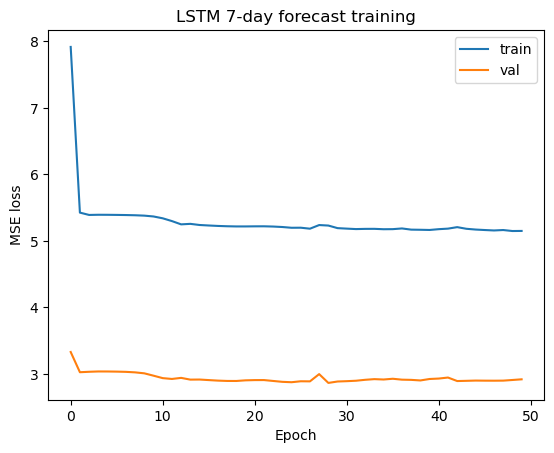

In [15]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.title("LSTM 7-day forecast training")
plt.show()


In [16]:
import numpy as np

model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)             
        all_preds.append(outputs.cpu().numpy())
        all_targets.append(batch_y.numpy())

y_pred = np.concatenate(all_preds, axis=0)    
y_true = np.concatenate(all_targets, axis=0)  

print("y_pred shape:", y_pred.shape)
print("y_true shape:", y_true.shape)


y_pred shape: (477, 7)
y_true shape: (477, 7)


In [17]:

rmse_all = np.sqrt(((y_pred - y_true) ** 2).mean())
print("Overall RMSE over 7-day horizon:", rmse_all)


rmse_per_step = np.sqrt(((y_pred - y_true) ** 2).mean(axis=0))
for k in range(y_pred.shape[1]):
    print(f"Day {k+1} RMSE:", rmse_per_step[k])


Overall RMSE over 7-day horizon: 2.0585034
Day 1 RMSE: 2.035013
Day 2 RMSE: 2.041916
Day 3 RMSE: 2.0500743
Day 4 RMSE: 2.0681753
Day 5 RMSE: 2.0662003
Day 6 RMSE: 2.0689266
Day 7 RMSE: 2.0788364


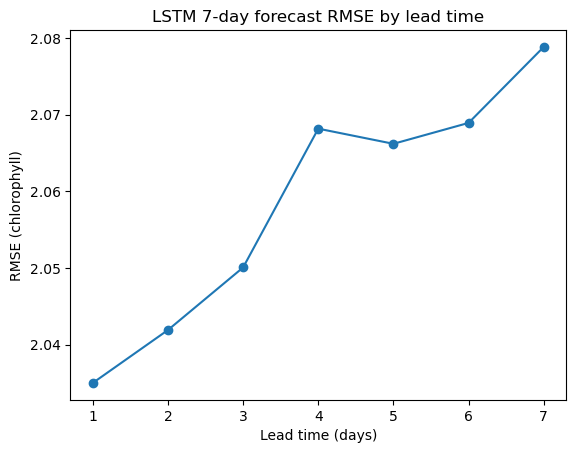

In [18]:
plt.figure()
plt.plot(range(1, y_pred.shape[1] + 1), rmse_per_step, marker="o")
plt.xlabel("Lead time (days)")
plt.ylabel("RMSE (chlorophyll)")
plt.title("LSTM 7-day forecast RMSE by lead time")
plt.show()


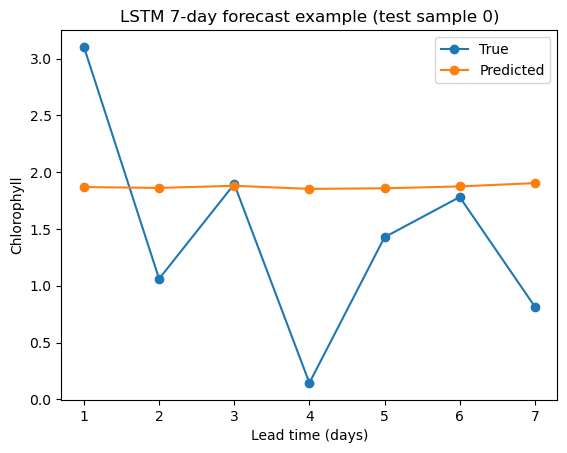

In [19]:
sample_id = 0  

plt.figure()
plt.plot(range(1, 8), y_true[sample_id], marker="o", label="True")
plt.plot(range(1, 8), y_pred[sample_id], marker="o", label="Predicted")
plt.xlabel("Lead time (days)")
plt.ylabel("Chlorophyll")
plt.title(f"LSTM 7-day forecast example (test sample {sample_id})")
plt.legend()
plt.show()


In [20]:
last_chl = X_test[:, -1, 0]  
baseline_persist = np.tile(last_chl[:, None], (1, y_test.shape[1]))  

rmse_all_persist = np.sqrt(((baseline_persist - y_test) ** 2).mean())
rmse_per_step_persist = np.sqrt(((baseline_persist - y_test) ** 2).mean(axis=0))

print("Persistence baseline - overall RMSE:", rmse_all_persist)
for k in range(y_test.shape[1]):
    print(f"Persistence baseline - Day {k+1} RMSE:", rmse_per_step_persist[k])



Persistence baseline - overall RMSE: 3.066265895488792
Persistence baseline - Day 1 RMSE: 3.044841428190157
Persistence baseline - Day 2 RMSE: 3.086745555293413
Persistence baseline - Day 3 RMSE: 3.058071170845384
Persistence baseline - Day 4 RMSE: 3.07847144220364
Persistence baseline - Day 5 RMSE: 3.0698461284853025
Persistence baseline - Day 6 RMSE: 3.080344351231268
Persistence baseline - Day 7 RMSE: 3.0452563218487043


In [22]:
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)             
        all_preds.append(outputs.cpu().numpy())
        all_targets.append(batch_y.numpy())

y_pred = np.concatenate(all_preds, axis=0)    
y_true = np.concatenate(all_targets, axis=0) 

print("y_pred shape:", y_pred.shape)
print("y_true shape:", y_true.shape)


y_pred shape: (477, 7)
y_true shape: (477, 7)


In [24]:

rmse_all_lstm = np.sqrt(((y_pred - y_true) ** 2).mean())
print("LSTM - overall RMSE:", rmse_all_lstm)


rmse_per_step_lstm = np.sqrt(((y_pred - y_true) ** 2).mean(axis=0))
for k in range(y_pred.shape[1]):
    print(f"LSTM - Day {k+1} RMSE:", rmse_per_step_lstm[k])


LSTM - overall RMSE: 2.0585034
LSTM - Day 1 RMSE: 2.035013
LSTM - Day 2 RMSE: 2.041916
LSTM - Day 3 RMSE: 2.0500743
LSTM - Day 4 RMSE: 2.0681753
LSTM - Day 5 RMSE: 2.0662003
LSTM - Day 6 RMSE: 2.0689266
LSTM - Day 7 RMSE: 2.0788364


In [25]:
print("Overall RMSE - LSTM:       ", rmse_all_lstm)
print("Overall RMSE - Persistence:", rmse_all_persist)

print("\nPer-day RMSE comparison:")
for k in range(7):
    print(f"Day {k+1}: LSTM = {rmse_per_step_lstm[k]:.3f}, "
          f"Persistence = {rmse_per_step_persist[k]:.3f}")


Overall RMSE - LSTM:        2.0585034
Overall RMSE - Persistence: 3.066265895488792

Per-day RMSE comparison:
Day 1: LSTM = 2.035, Persistence = 3.045
Day 2: LSTM = 2.042, Persistence = 3.087
Day 3: LSTM = 2.050, Persistence = 3.058
Day 4: LSTM = 2.068, Persistence = 3.078
Day 5: LSTM = 2.066, Persistence = 3.070
Day 6: LSTM = 2.069, Persistence = 3.080
Day 7: LSTM = 2.079, Persistence = 3.045


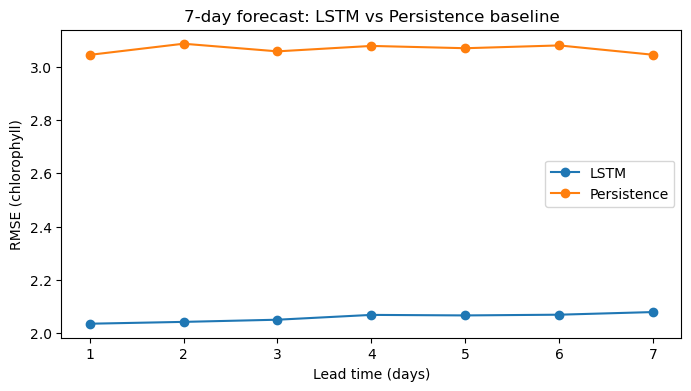

In [26]:
days = np.arange(1, 8)

plt.figure(figsize=(8,4))
plt.plot(days, rmse_per_step_lstm, marker="o", label="LSTM")
plt.plot(days, rmse_per_step_persist, marker="o", label="Persistence")
plt.xlabel("Lead time (days)")
plt.ylabel("RMSE (chlorophyll)")
plt.title("7-day forecast: LSTM vs Persistence baseline")
plt.legend()
plt.show()


In [27]:
skill_overall = 1 - (rmse_all_lstm**2) / (rmse_all_persist**2)
print("Overall skill vs persistence:", skill_overall)

skill_per_step = 1 - (rmse_per_step_lstm**2) / (rmse_per_step_persist**2)
for k in range(7):
    print(f"Day {k+1} skill:", skill_per_step[k])


Overall skill vs persistence: 0.5493041522980708
Day 1 skill: 0.5533112618668323
Day 2 skill: 0.5624032808079696
Day 3 skill: 0.5505886688841394
Day 4 skill: 0.548659372775633
Day 5 skill: 0.5469860030856348
Day 6 skill: 0.5488804973428234
Day 7 skill: 0.5339924783103587


In [28]:

X_chl_df = pd.DataFrame({
    "chl": df["chlorophyll"].values,
}, index=df.index)


y_chl_df = pd.DataFrame({
    "chl": df["chlorophyll"].values
}, index=df.index)

mean_chl = X_chl_df.mean()
std_chl  = X_chl_df.std()
X_chl_std = (X_chl_df - mean_chl) / std_chl

X_all_chl = X_chl_std.to_numpy()   # (T, 1)
y_all_chl = y_chl_df.to_numpy()    # (T, 1)

print("X_all_chl shape:", X_all_chl.shape)
print("y_all_chl shape:", y_all_chl.shape)


X_all_chl shape: (3216, 1)
y_all_chl shape: (3216, 1)


In [29]:
slider = 30     
horizon = 7     

X_seq_list_chl = []
y_seq_list_chl = []

for i in range(0, X_all_chl.shape[0] - slider - horizon + 1):

    X_seq_list_chl.append(X_all_chl[i : i + slider, :])         
   
    y_seq_list_chl.append(y_all_chl[i + slider : i + slider + horizon, 0])  

X_seq_chl = np.array(X_seq_list_chl)   # (N_samples, 30, 1)
y_seq_chl = np.array(y_seq_list_chl)   # (N_samples, 7)

print("X_seq_chl shape:", X_seq_chl.shape)
print("y_seq_chl shape:", y_seq_chl.shape)


X_seq_chl shape: (3180, 30, 1)
y_seq_chl shape: (3180, 7)


In [30]:
num_samples_chl = X_seq_chl.shape[0]

train_size_chl = int(num_samples_chl * 0.7)
val_size_chl   = int(num_samples_chl * 0.15)
test_size_chl  = num_samples_chl - train_size_chl - val_size_chl

X_train_chl = X_seq_chl[:train_size_chl]
y_train_chl = y_seq_chl[:train_size_chl]

X_val_chl   = X_seq_chl[train_size_chl : train_size_chl + val_size_chl]
y_val_chl   = y_seq_chl[train_size_chl : train_size_chl + val_size_chl]

X_test_chl  = X_seq_chl[train_size_chl + val_size_chl :]
y_test_chl  = y_seq_chl[train_size_chl + val_size_chl :]

print("Train (chl-only):", X_train_chl.shape, y_train_chl.shape)
print("Val   (chl-only):", X_val_chl.shape,   y_val_chl.shape)
print("Test  (chl-only):", X_test_chl.shape,  y_test_chl.shape)


Train (chl-only): (2226, 30, 1) (2226, 7)
Val   (chl-only): (477, 30, 1) (477, 7)
Test  (chl-only): (477, 30, 1) (477, 7)


In [31]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset_chl = TensorDataset(
    torch.FloatTensor(X_train_chl),
    torch.FloatTensor(y_train_chl)
)
val_dataset_chl = TensorDataset(
    torch.FloatTensor(X_val_chl),
    torch.FloatTensor(y_val_chl)
)
test_dataset_chl = TensorDataset(
    torch.FloatTensor(X_test_chl),
    torch.FloatTensor(y_test_chl)
)

batch_size = 64

train_loader_chl = DataLoader(train_dataset_chl, batch_size=batch_size, shuffle=False)
val_loader_chl   = DataLoader(val_dataset_chl,   batch_size=batch_size, shuffle=False)
test_loader_chl  = DataLoader(test_dataset_chl,  batch_size=batch_size, shuffle=False)


In [32]:
input_size_chl  = X_train_chl.shape[2]      
hidden_size_chl = 64
output_size_chl = y_train_chl.shape[-1]     
num_layers_chl  = 2

model_chl = LSTMModel(
    input_size=input_size_chl,
    hidden_size=hidden_size_chl,
    output_size=output_size_chl,
    activation="ReLU",
    num_layers=num_layers_chl
).to(device)

criterion_chl = nn.MSELoss()
optimizer_chl = torch.optim.Adam(model_chl.parameters(), lr=1e-3)

model_chl


LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=7, bias=True)
  )
)

In [33]:
num_epochs = 50

train_losses_chl = []
val_losses_chl = []

for epoch in range(num_epochs):
    # ---- train ----
    model_chl.train()
    running_train_loss = 0.0
    n_train = 0
    
    for batch_X, batch_y in train_loader_chl:
        batch_X = batch_X.to(device)   
        batch_y = batch_y.to(device)   

        optimizer_chl.zero_grad()
        outputs = model_chl(batch_X)   
        loss = criterion_chl(outputs, batch_y)
        loss.backward()
        optimizer_chl.step()

        batch_size_now = batch_X.size(0)
        running_train_loss += loss.item() * batch_size_now
        n_train += batch_size_now

    epoch_train_loss = running_train_loss / n_train
    train_losses_chl.append(epoch_train_loss)

    
    model_chl.eval()
    running_val_loss = 0.0
    n_val = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader_chl:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            outputs = model_chl(batch_X)
            loss = criterion_chl(outputs, batch_y)

            batch_size_now = batch_X.size(0)
            running_val_loss += loss.item() * batch_size_now
            n_val += batch_size_now

    epoch_val_loss = running_val_loss / n_val
    val_losses_chl.append(epoch_val_loss)

    print(f"[chl-only] Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")


[chl-only] Epoch 1/50 - Train Loss: 7.6912 - Val Loss: 3.4350
[chl-only] Epoch 2/50 - Train Loss: 5.4423 - Val Loss: 3.0530
[chl-only] Epoch 3/50 - Train Loss: 5.3942 - Val Loss: 3.0364
[chl-only] Epoch 4/50 - Train Loss: 5.3937 - Val Loss: 3.0385
[chl-only] Epoch 5/50 - Train Loss: 5.3932 - Val Loss: 3.0385
[chl-only] Epoch 6/50 - Train Loss: 5.3922 - Val Loss: 3.0377
[chl-only] Epoch 7/50 - Train Loss: 5.3911 - Val Loss: 3.0368
[chl-only] Epoch 8/50 - Train Loss: 5.3901 - Val Loss: 3.0359
[chl-only] Epoch 9/50 - Train Loss: 5.3890 - Val Loss: 3.0349
[chl-only] Epoch 10/50 - Train Loss: 5.3878 - Val Loss: 3.0336
[chl-only] Epoch 11/50 - Train Loss: 5.3863 - Val Loss: 3.0317
[chl-only] Epoch 12/50 - Train Loss: 5.3839 - Val Loss: 3.0268
[chl-only] Epoch 13/50 - Train Loss: 5.3792 - Val Loss: 3.0102
[chl-only] Epoch 14/50 - Train Loss: 5.3708 - Val Loss: 2.9853
[chl-only] Epoch 15/50 - Train Loss: 5.3356 - Val Loss: 2.9080
[chl-only] Epoch 16/50 - Train Loss: 5.2730 - Val Loss: 2.9309
[

In [34]:
model_chl.eval()

all_preds_chl = []
all_targets_chl = []

with torch.no_grad():
    for batch_X, batch_y in test_loader_chl:
        batch_X = batch_X.to(device)
        outputs = model_chl(batch_X)             
        all_preds_chl.append(outputs.cpu().numpy())
        all_targets_chl.append(batch_y.numpy())

y_pred_chl = np.concatenate(all_preds_chl, axis=0)    
y_true_chl = np.concatenate(all_targets_chl, axis=0) 

print("y_pred_chl shape:", y_pred_chl.shape)
print("y_true_chl shape:", y_true_chl.shape)


y_pred_chl shape: (477, 7)
y_true_chl shape: (477, 7)


In [35]:
rmse_all_chl = np.sqrt(((y_pred_chl - y_true_chl) ** 2).mean())
rmse_per_step_chl = np.sqrt(((y_pred_chl - y_true_chl) ** 2).mean(axis=0))

print("Chl-only LSTM - overall RMSE:", rmse_all_chl)
for k in range(7):
    print(f"Chl-only LSTM - Day {k+1} RMSE:", rmse_per_step_chl[k])


Chl-only LSTM - overall RMSE: 2.0341957
Chl-only LSTM - Day 1 RMSE: 2.0213013
Chl-only LSTM - Day 2 RMSE: 2.0247734
Chl-only LSTM - Day 3 RMSE: 2.0293837
Chl-only LSTM - Day 4 RMSE: 2.037531
Chl-only LSTM - Day 5 RMSE: 2.0377414
Chl-only LSTM - Day 6 RMSE: 2.039914
Chl-only LSTM - Day 7 RMSE: 2.048594


In [36]:
print("Overall RMSE comparison:")
print("LSTM(chl + precip):", rmse_all_lstm)
print("LSTM(chl only)    :", rmse_all_chl)

print("\nPer-day RMSE comparison (Day 1–7):")
for k in range(7):
    print(f"Day {k+1}: chl+precip = {rmse_per_step_lstm[k]:.3f}, "
          f"chl-only = {rmse_per_step_chl[k]:.3f}")


Overall RMSE comparison:
LSTM(chl + precip): 2.0585034
LSTM(chl only)    : 2.0341957

Per-day RMSE comparison (Day 1–7):
Day 1: chl+precip = 2.035, chl-only = 2.021
Day 2: chl+precip = 2.042, chl-only = 2.025
Day 3: chl+precip = 2.050, chl-only = 2.029
Day 4: chl+precip = 2.068, chl-only = 2.038
Day 5: chl+precip = 2.066, chl-only = 2.038
Day 6: chl+precip = 2.069, chl-only = 2.040
Day 7: chl+precip = 2.079, chl-only = 2.049


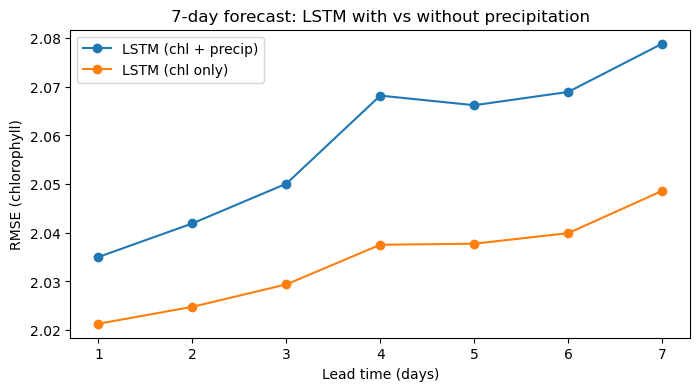

In [37]:
days = np.arange(1, 8)

plt.figure(figsize=(8,4))
plt.plot(days, rmse_per_step_lstm, marker="o", label="LSTM (chl + precip)")
plt.plot(days, rmse_per_step_chl, marker="o", label="LSTM (chl only)")
plt.xlabel("Lead time (days)")
plt.ylabel("RMSE (chlorophyll)")
plt.title("7-day forecast: LSTM with vs without precipitation")
plt.legend()
plt.show()
